In [ ]:
import csv
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

**توضیحات**

پس از اینکه دیتا را استخراج کردم، ابتدا مشاهده میکنیم تقریباً توزیع برچسب ها یکسان است، اما دو برچسب را نداریم که ممکن است برای وان هات کردن مشکل باشد اما با تابعی که استفاده کردم این مشکل رفع شده است منتهی در انتها برای رسم ماتریس کانفیوژن حواسم به این موضوع بوده است.

معماری شبکه تقریبا شبیه به آن چیزی است که در صورت تمرین آمده است اما من چند لایه بیشتر اضافه کردم و نیز به فیلترها افزوده ام، هم چنین برای جلوگیری از اووفیتینگ نیز لایه های دراپ آوت و بچ نرمالیزیشن نیز استفاده کردم که دقت تست به 91 درصد رسیده است.


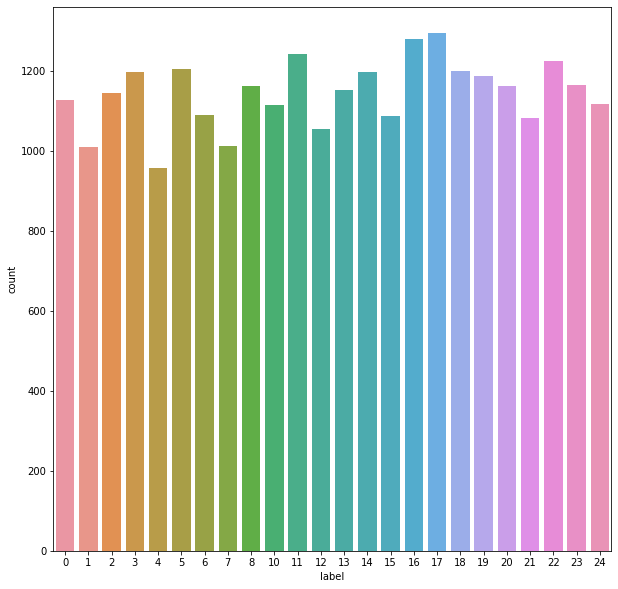

"\nimages = np.array(temp_images).astype('float')\nlabels = np.array(temp_labels).astype('float')\n"

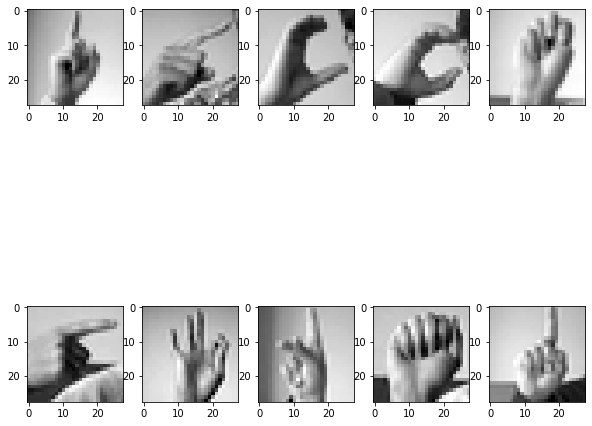

In [ ]:
#Loading Data
train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')
y_train = train_df['label']
y_test = test_df['label']
Y_test = y_test
Y_train = y_train
plt.figure(figsize = (10,10))
sns.countplot(y_train)
plt.show()

del train_df['label']
del test_df['label']
X_train = train_df.values
X_test = test_df.values
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)

X_train = X_train / 255.0
X_test = X_test / 255.0

f, ax = plt.subplots(2,5) 
f.set_size_inches(10, 10)
for i in range(5):
  ax[0,i].imshow(X_train[i].reshape(28, 28) , cmap = "gray")
for i in range(5):
  ax[1,i].imshow(X_test[i].reshape(28, 28) , cmap = "gray")

'''
images = np.array(temp_images).astype('float')
labels = np.array(temp_labels).astype('float')
'''

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.GaussianDropout(0.5),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation='softmax')
])

opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)

model.compile(optimizer = opt,
              loss ='categorical_crossentropy',
              metrics = ['acc'])

X_train = np.expand_dims(X_train,axis=3)
X_test = np.expand_dims(X_test,axis=3)
history = model.fit(X_train[:22500], y_train[:22500], epochs=10,validation_data=(np.array(X_train[22500:-1]),np.array(y_train[22500:-1])), batch_size=32, verbose=0)

score = model.evaluate(X_test, y_test, batch_size=64)

113/113 [==============================] - 1s 12ms/step - loss: 0.2786 - acc: 0.9115


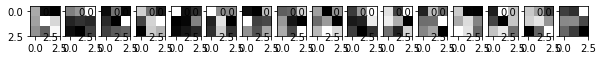

In [ ]:
w = model.layers[0].get_weights()[0]
w = w.reshape(16,3,3)

f, ax = plt.subplots(1,16) 
f.set_size_inches(10, 10)
for i in range(16):
  ax[i].imshow(w[i], cmap = "gray")

در اینجا وزن های یادگیری شده در لایه اول را استخراج کرده ام و به تصویر کشیده ام.
چون 16 تا فیلتر داشتیم تعداد این تصاویر 16 تاست.

همانطور که مشاهده می شود در هر فیلتر دو درایه از ماتریس است که مقدار زیاد تری دارد که در فیلتر های مختلف جای آن متفاوت است که به نوعی لبه های مختلف شکل را از تصویر بر میدارد تا بتواند به انواع مختلف بر روی شکل یادگیری کند.

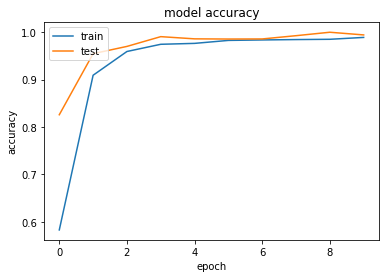

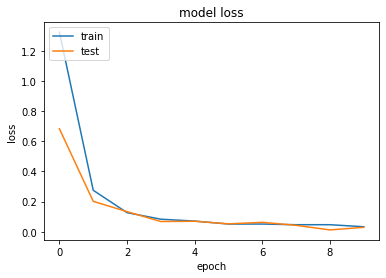

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

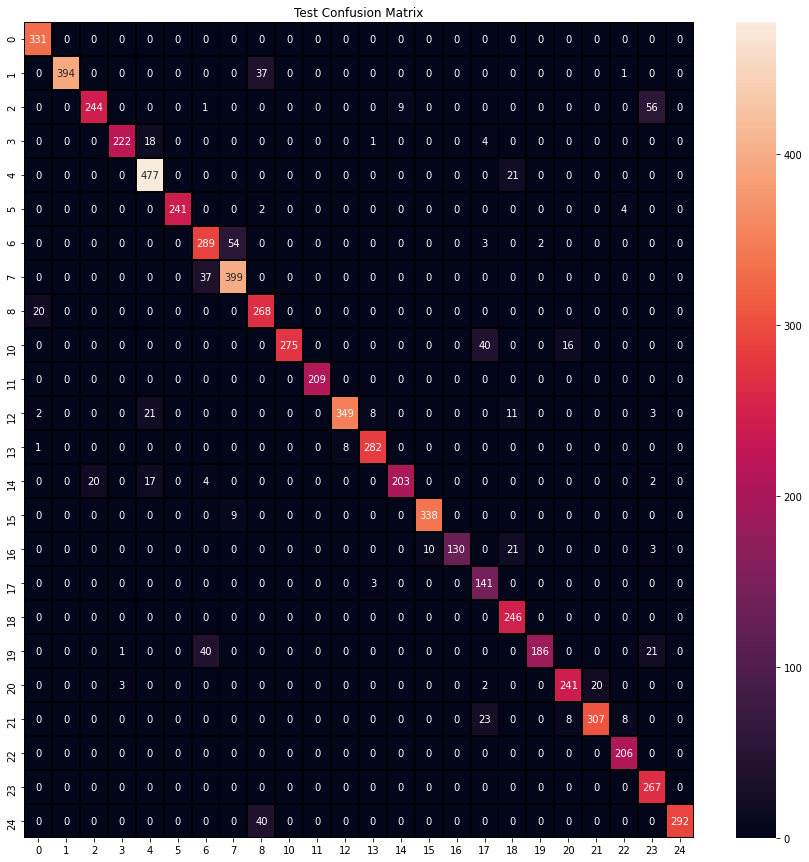

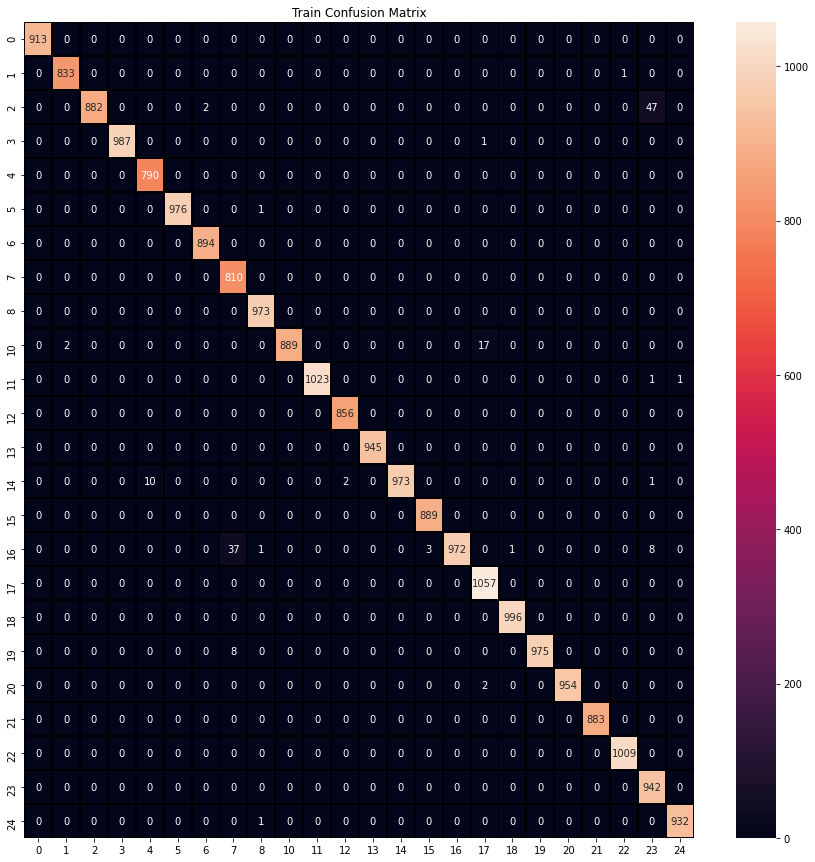

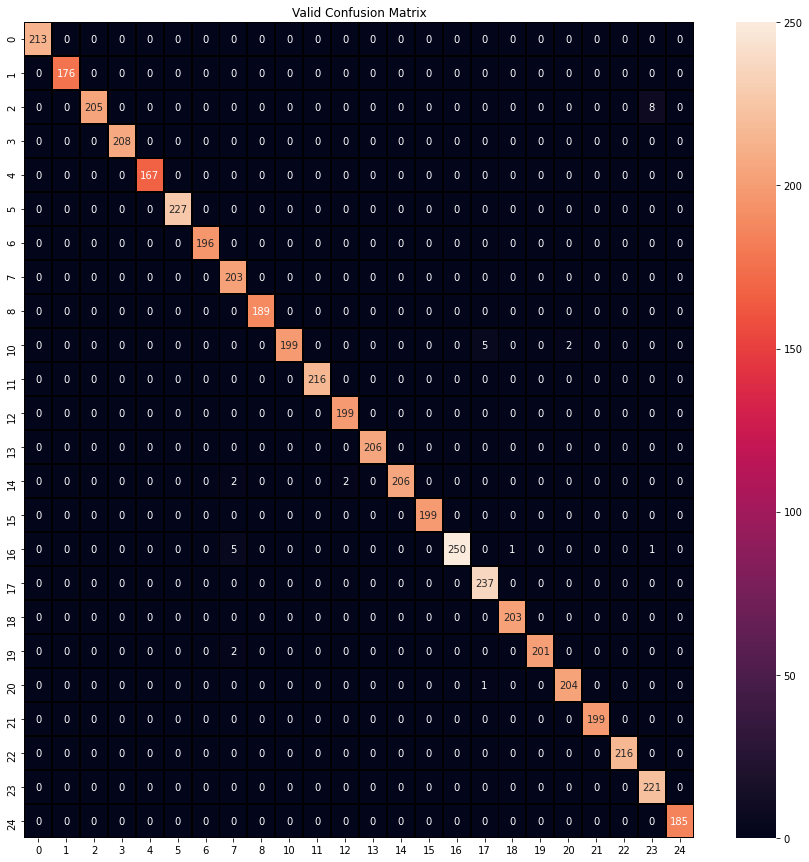

In [ ]:
predictions_test = np.argmax(model.predict(X_test), axis=-1)
for i in range(len(predictions_test)):
    if(predictions_test[i] >= 9):
        predictions_test[i] += 1

predictions_train = np.argmax(model.predict(X_train[:22500]), axis=-1)
for i in range(len(predictions_train)):
    if(predictions_train[i] >= 9):
        predictions_train[i] += 1
predictions_valid= np.argmax(model.predict(X_train[22500:-1]), axis=-1)
for i in range(len(predictions_valid)):
    if(predictions_valid[i] >= 9):
        predictions_valid[i] += 1

cm_test = confusion_matrix(Y_test,predictions_test)
cm_train = confusion_matrix(Y_train[:22500],predictions_train)
cm_valid = confusion_matrix(Y_train[22500:-1],predictions_valid)

cm_test = pd.DataFrame(cm_test , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])
cm_train = pd.DataFrame(cm_train , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])
cm_valid = pd.DataFrame(cm_valid , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])

plt.figure(figsize = (15,15))
plt.title('Test Confusion Matrix')
sns.heatmap(cm_test, linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

plt.figure(figsize = (15,15))
plt.title('Train Confusion Matrix')
sns.heatmap(cm_train, linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

plt.figure(figsize = (15,15))
plt.title('Valid Confusion Matrix')
sns.heatmap(cm_valid, linecolor = 'black' , linewidth = 1 , annot = True, fmt='')


In [ ]:
acc_test = len(predictions_test[predictions_test==Y_test])/len(y_test)
acc_train = len(predictions_train[predictions_train==Y_train[:22500]])/len(y_train[:22500])
acc_valid = len(predictions_valid[predictions_valid==Y_train[22500:-1]])/len(y_train[22500:-1])
print([acc_test,acc_valid,acc_train])

[0.9114612381483547, 0.994146144529673, 0.9934666666666667]
